# Cars 4 - Not a Pixar Movie

## INFO 1998 Final Project

### Grant Rineheimer and Benjamin Tang and Dylan Tom

This project performs an explorative data and predictive analysis on a used car dataset. 

We want to answer the following questions
1. What features can we use to predict the price of a used car? (Regression)
2. Given certain features, can we predict the manufacturer of the car? (Classification)

The approach is outlined as follows:
1. Preprocessing and cleaning the dataset
2. Data Visualization
3. Machine Learning Models
4. Analysis

Source of Data: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

In [2]:
#Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import datasets

In [2]:
#Import Dataset
data = pd.read_csv('vehicles.csv')
df = pd.DataFrame(data)
df.shape

(426880, 26)

This dataset has 426,880 instances with 26 features. Shown below are the names of the attributes and the first 5 rows of the dataframe. There are many rows which have NaN as an entry which do not provide additional features to determine a correlation or make predictions. For example, 'url', 'region_url', 'image url', 'description' are outdated and non-useful columns which can be removed to make the dataframe easier to read. 

In [3]:
%pprint
list(df.columns)

Pretty printing has been turned OFF


['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']

In [4]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


## Data Preprocessing and Cleaning

The entries in this dataset are very noisy. There are many NaN values, redundant or insiginficantly useful columns, and potentially repetition of data entries. In a dataset of 426,880 entries, the useful data must be extracted and preprocessed. 

SUBSETTING: We begin the data preprocessing by removing the following attributes which contain URLs which will not be processed in this dataset. 

In [5]:
df_useful = df.drop(['url','region_url','image_url','description','county'], axis=1) 

In [6]:
#Number of unique values in manufacturer, condition, fuel,type, paint_color, drive
df_useful.nunique(axis=0)

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118264
drive                3
size                 4
type                13
paint_color         12
state               51
lat              53181
long             53772
posting_date    381536
dtype: int64

In [7]:
#Curious in the attributes with at most 15 unique values (<= 15)
print('unique conditions: ', df_useful.condition.unique())
print('unique cylinders: ', df_useful.cylinders.unique())
print('unique fuel types: ', df_useful.fuel.unique())
print('unique titles: ', df_useful.title_status.unique())
print('unique transmissions: ', df_useful.transmission.unique())
print('unique drives: ', df_useful.drive.unique())
print('unique types: ', df_useful.type.unique())
print('unique size: ', df_useful['size'].unique())
print('unique paint: ', df_useful.paint_color.unique())

unique conditions:  [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
unique cylinders:  [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
unique fuel types:  [nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
unique titles:  [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
unique transmissions:  [nan 'other' 'automatic' 'manual']
unique drives:  [nan 'rwd' '4wd' 'fwd']
unique types:  [nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
unique size:  [nan 'full-size' 'mid-size' 'compact' 'sub-compact']
unique paint:  [nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']


In [8]:
def str_to_int(df):
    """
    Modifies the dataframe to convert a string to an int
    
    Example: 8 cylinders -> 8 
    
    Parameter df: A dataframe to modify 
    Precondition: Dataframe with at least 1 column with a string containing at least one digit
    """
    
    for i in range(len(df)):
        string_cylinder = df['cylinders'][i]
        if type(string_cylinder) == str and string_cylinder != 'other':
            df['cylinders'][i] = int(string_cylinder[0])

In [9]:
def convert_date(df):
    """
    Modifies the dataframe to format the posting date, DO NOT need time
    
    Example: 2021-05-04T12:31:18-0500 -> 05/04/2021
    
    Parameter df: A dataframe to modify 
    Precondition: Dataframe with a date column in the above format
    """
    
    for i in range(len(df)):
        s = df['posting_date'][i]
        
        if type(s) == str:
            year = s[:4]
            month = s[5:7]
            day = s[8:10]

            df['posting_date'][i] = month + '/' + day + '/' + year

In [10]:
#Inefficient but allows control over what variables are overwritten or modified
str_to_int(df_useful)
convert_date(df_useful)

<ipython-input-8-623324915a02>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cylinders'][i] = int(string_cylinder[0])
<ipython-input-9-7224026092ee>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['posting_date'][i] = month + '/' + day + '/' + year


The categorical data in this dataset are: manufacturer, model, conditions, fuel, title_status, transmission, drive, size, type, paint_color

The continuous data in this dataset are: price, year, cylinders, odometer, posting-date


FILTERING: to modify the dataset to include only useful rows

In [12]:
#Number of null values in each column in dataframe
df_useful.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [13]:
#Need to choose which rows to drop
df_final = df_useful.dropna(subset = ['year','cylinders'])

#Reindex the dataframe
df_final.reset_index(drop=True, inplace=True)

#Retained 
df_final.shape

(248084, 21)

In [14]:
df_final['year'] = df_final['year'].astype(int)

<ipython-input-14-98260ffd4044>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['year'] = df_final['year'].astype(int)


In [15]:
df_final.describe()

,id,price,year,odometer,lat,long
count,2.480840e+05,2.480840e+05,248084.000000,2.465850e+05,242819.000000,242819.000000
mean,7.311672e+09,6.629931e+04,2010.330275,1.045731e+05,38.652560,-95.509484
std,4.308408e+06,1.242535e+07,9.815420,2.114410e+05,5.932695,18.644916
min,7.301584e+09,0.000000e+00,1900.000000,0.000000e+00,-84.122245,-159.827728
25%,7.308403e+09,5.500000e+03,2007.000000,4.700000e+04,34.746623,-114.465026
50%,7.312860e+09,1.199900e+04,2013.000000,9.439500e+04,39.338500,-89.600000
75%,7.315307e+09,2.499000e+04,2016.000000,1.400000e+05,42.484503,-81.152649
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,82.252826,173.885502


ENCODING: to convert the categorical data to numerical data.

In [16]:
def encode_dummies(df, column):
    """
    Encodes dummies for column on DataFrame df.
    Parameter column: String name of column to be encoded as dummies
    Parameter df: DataFrame that is receiving dummies
    Requires: column is of type String and is a column (axis=1) in df, df is a DataFrame
    """
    dummies = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([column], axis=1)
    return df

In [17]:
df_final = encode_dummies(df=df_final, column='fuel')
df_final = encode_dummies(df=df_final, column='size')
df_final = encode_dummies(df=df_final, column='condition')
df_final = encode_dummies(df=df_final, column='transmission')
df_final = encode_dummies(df=df_final, column='drive')

In [18]:
df_final.head()

,id,region,price,year,manufacturer,model,cylinders,odometer,title_status,VIN,...,condition_salvage,condition_nan,transmission_automatic,transmission_manual,transmission_other,transmission_nan,drive_4wd,drive_fwd,drive_rwd,drive_nan
0,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,8,57923.0,clean,3GTP1VEC4EG551563,...,0,0,0,0,1,0,0,0,0,1
1,7316814758,auburn,22590,2010,chevrolet,silverado 1500,8,71229.0,clean,1GCSCSE06AZ123805,...,0,0,0,0,1,0,0,0,0,1
2,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,8,19160.0,clean,3GCPWCED5LG130317,...,0,0,0,0,1,0,0,0,0,1
3,7316743432,auburn,30990,2017,toyota,tundra double cab sr,8,41124.0,clean,5TFRM5F17HX120972,...,0,0,0,0,1,0,0,0,0,1
4,7316356412,auburn,15000,2013,ford,f-150 xlt,6,128000.0,clean,NaN,...,0,0,1,0,0,0,0,0,1,0


In [19]:
df_final.to_csv('final_vehicles.csv')

As data preprocessing took a long time, the final dataframe is stored in 'final_vehicles.csv' so that it can be accessed easily. 

In [4]:
df_final = pd.read_csv('final_vehicles.csv')
df_final = pd.DataFrame(df_final)

## Visualization

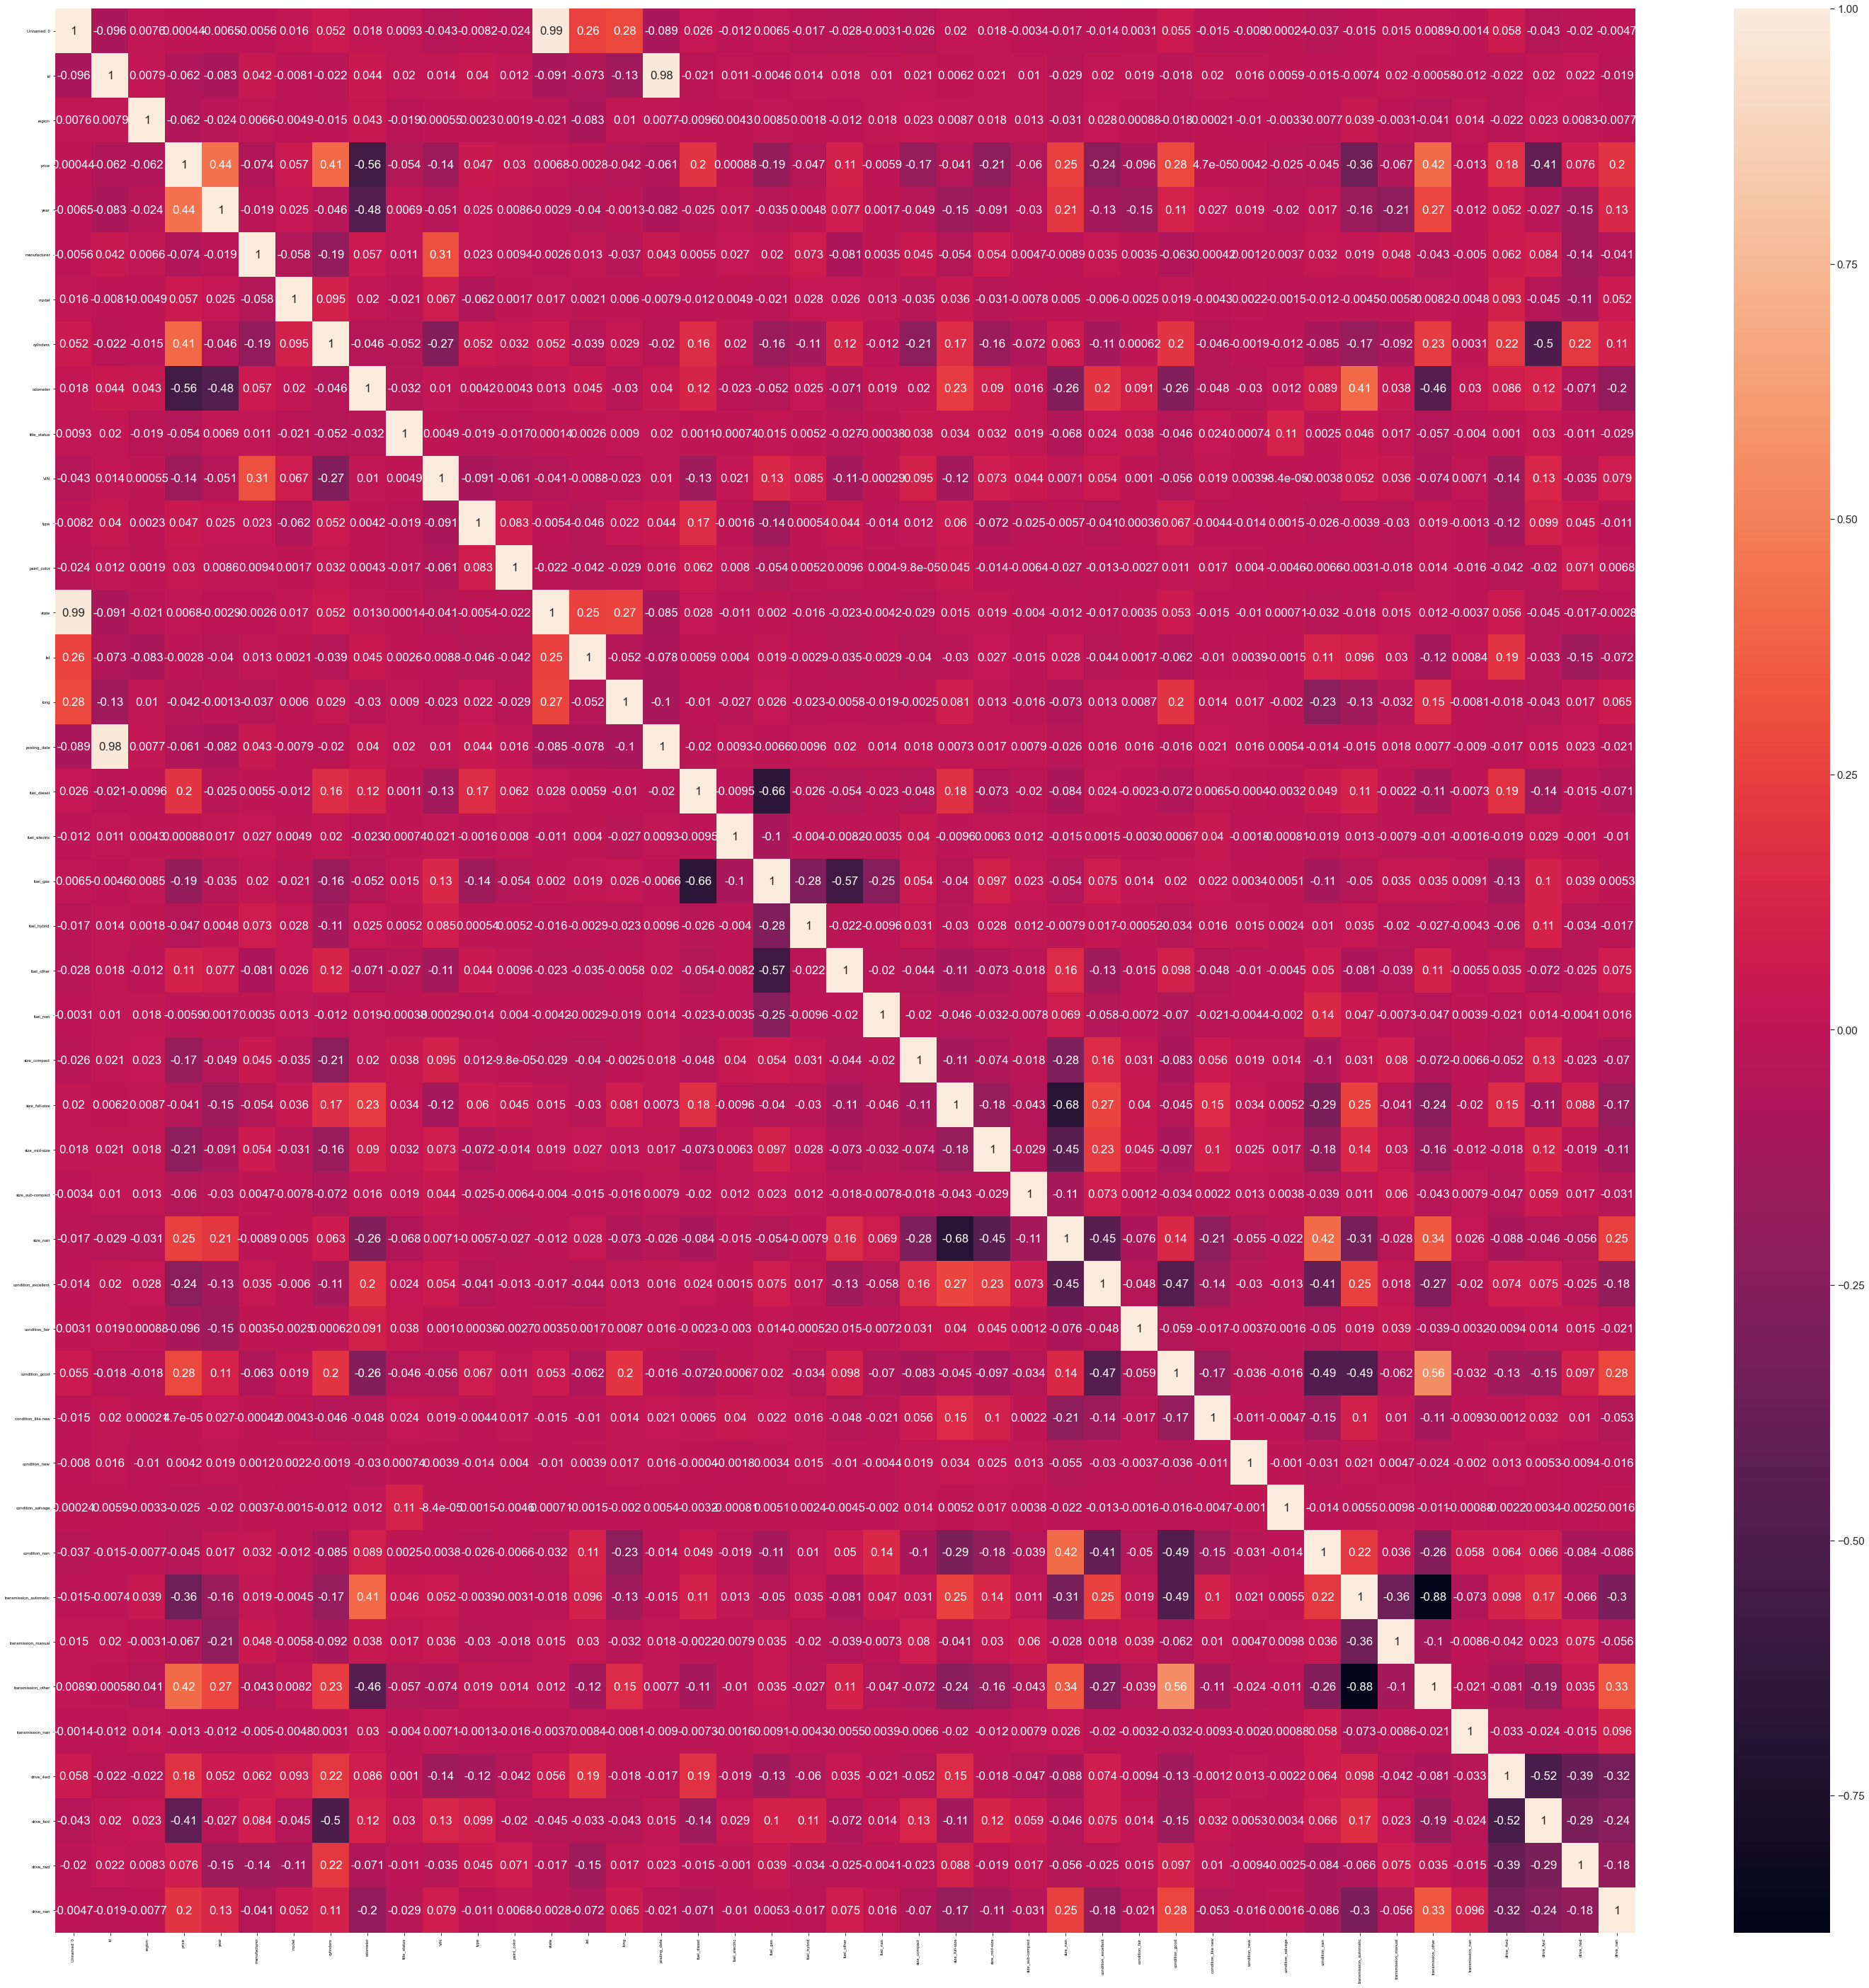

In [5]:
#Visualization 1
le = LabelEncoder()
for i in df_final.columns:
    df_final = df_final.dropna()
    df_final[i] = le.fit_transform(df_final[i])

# split date into year, month, day columns
    
df_final.reset_index(drop = True, inplace = True)
df_final.head()


corrMatrix = df_final.corr()


plt.rcParams.update({'font.size': 6})
plt.subplots(figsize=(50,50))
sb.set(font_scale=1.4)
sb.heatmap(corrMatrix, annot=True)

plt.show()


The above heatmap shows the relationship between the variables in the dataframe. Labeled along the axes are the specific variable. The intensity of the color indicates the strength of the correlation between two of the variables with a lighter color indicating a stronger correlation. It is difficult to determine which variables have the best relationship with price of the car (the goal of the first machine learning model) so we will print out the correlation matrix to determine a numerical basis for choosing the "best" predictors. 

In [6]:
print(corrMatrix)

                        Unnamed: 0        id    region     price      year  \
Unnamed: 0                1.000000 -0.095726  0.007552  0.000437 -0.006528   
id                       -0.095726  1.000000  0.007895 -0.062276 -0.082940   
region                    0.007552  0.007895  1.000000 -0.062428 -0.024490   
price                     0.000437 -0.062276 -0.062428  1.000000  0.440466   
year                     -0.006528 -0.082940 -0.024490  0.440466  1.000000   
manufacturer             -0.005619  0.042101  0.006578 -0.074001 -0.018822   
model                     0.016013 -0.008063 -0.004936  0.056521  0.025058   
cylinders                 0.051922 -0.021825 -0.014798  0.407058 -0.045506   
odometer                  0.017736  0.043698  0.042955 -0.560732 -0.481856   
title_status              0.009321  0.019710 -0.019197 -0.054437  0.006940   
VIN                      -0.043491  0.014265  0.000552 -0.140538 -0.051035   
type                     -0.008227  0.040017  0.002333  0.047132

For the second visualiztion, we create a clustered bar graph showing the amount of each car size for the top 5 manufacturers.

In [7]:
# Visualization 2
# Find top 5 manufacturers
manufacturers, count = np.unique(df_final['manufacturer'], return_counts=True)
manufacturers = np.reshape(manufacturers, (41,1))
count = np.reshape(count, (41,1))
count_manufacturers = pd.DataFrame(np.concatenate((manufacturers,count), axis=1), columns=['Manufacturer', 'Count'])

sorted_count_manufacturers = count_manufacturers.sort_values('Count', ascending=False, ignore_index=True)

top_5 = np.array(sorted_count_manufacturers.iloc[:5,0])

# Top 5 Manufacturers are 13, 7, 38, 33, 14

df_classification = df_final[df_final['manufacturer'].isin(top_5)]

In [8]:
def nonzero_count(feature):
    """
    Counts the amount of non-zero entries for a specified feature of df_classification. Only makes sense for dummy variables.
    Parameter feature: String name of column to be counted.
    Requires: feature is of type String
    Returns: list of values of non-zero entries
    """
    values = []
    for maker in top_5:
        filtered = df_classification[df_classification['manufacturer'] == maker]
        values.append(np.count_nonzero(filtered[feature]))
    return values

Another visualization we can explore is the amount of each car size for the top 5 manufacturers. The only downside to this analysis is the identification of the top 5 manufacturers. They are numbers to assist in the numerical computations using the manufacturer but we were not able to go back to the original manufacturer names.

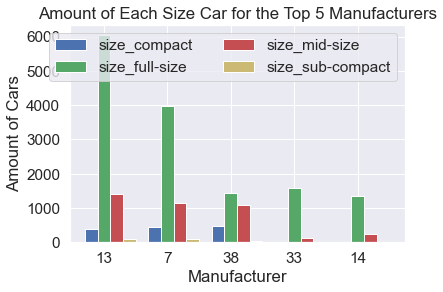

In [9]:
bar_width = 0.2
figure, axis = plt.subplots()
indexes = np.arange(5)
axis.bar(indexes, nonzero_count('size_compact'), bar_width, color='b', label='size_compact')
axis.bar(indexes + bar_width, nonzero_count('size_full-size'), bar_width, color='g', label='size_full-size')
axis.bar(indexes + bar_width*2, nonzero_count('size_mid-size'), bar_width, color='r', label='size_mid-size')
axis.bar(indexes + bar_width*3, nonzero_count('size_sub-compact'), bar_width, color='y', label='size_sub-compact')
axis.set_title('Amount of Each Size Car for the Top 5 Manufacturers')
axis.set_xlabel('Manufacturer')
axis.set_ylabel('Amount of Cars')
axis.set_xticks(indexes + bar_width)
axis.set_xticklabels(top_5)
axis.legend(ncol=2)

We perform a normalization on the price and year using the mean and standard deviation. A scatter plot is shown below.

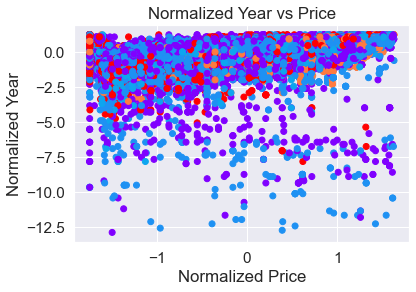

In [10]:
price_normalized = (df_classification['price']-df_classification['price'].mean())/df_classification['price'].std()
year_normalized = (df_classification['year']-df_classification['year'].mean())/df_classification['year'].std()

plt.scatter(price_normalized, year_normalized, c=df_classification['manufacturer'], cmap='rainbow')
plt.title('Normalized Year vs Price')
plt.xlabel('Normalized Price')
plt.ylabel('Normalized Year')
plt.show()

We will use these top 5 manufacturers in the second machine learning model in an attempt to classify the manufacturer based off of select features.

## Machine Learning 

### Regression Model

In [34]:
# Normalize the columns using min-max normalization
cols_to_norm = ['year','cylinders','odometer']
df_final[cols_to_norm] = df_final[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [35]:
# Predict the price of used car

model_price = LinearRegression()
X_p = df_final[["year","cylinders","odometer"]]
Y_p = df_final["price"]

x_tr_p, x_te_p, y_tr_p, y_te_p = train_test_split(X_p, Y_p, test_size=0.2, random_state=42)
model_price.fit(x_tr_p, y_tr_p)

# store the predictions for the test sets
model_price_preds = model_price.predict(x_te_p)

# find mean squared error of each model's predictions
price_MSE = mean_squared_error(y_te_p, model_price_preds)

print("price MSE:", price_MSE)

print("sklearn's score for price:", model_price.score(x_tr_p, y_tr_p))
test_goal_mean_p = y_te_p.mean()
baseline_p = np.full((len(model_price_preds),), test_goal_mean_p)
baseline_p_MSE = mean_squared_error(y_te_p, baseline_p)

score_p = 1 - price_MSE / baseline_p_MSE
print("computed score:", score_p)

price MSE: 1751140.7594195558
sklearn's score for price: 0.5113840303934348
computed score: 0.5075309554485086


### Analysis

Based on the output of the correlation matrix, we decided that the three best predictors of price was the year of the car, the number of cylinders in the car, and the odometer reading. At first we were going to choose two variables (price and number of cylinders) but a score of approximately 0.3 was outputted. The addition of the predictor "odometer" strengthened the model's score to 0.511. This shows that even the simple addition of one feature can improve a model significantly. Therefore, the answer to our question (What features can we use to predict the price of a used car?) is the year, the amount of cylinders, and the mileage on the odometer.



In [36]:
#example usage of the regression - the model predicts $6019 based off of the year, cylinder, and odometer
X_predict = [[1,0.938,0.014]] 
Y_predict = model_price.predict(X_predict)
Y_predict[0]

6019.1223596293785

### Classification Model

In [ ]:
X = df_classification.drop(['Unnamed: 0', 'id', 'region','price','year','manufacturer','model','cylinders','odometer','title_status','VIN','state','lat','long','posting_date'], axis=1)
Y = df_classification['manufacturer']
X_tr, X_te, Y_tr, Y_te = train_test_split(X,Y,test_size = 0.33, random_state = 42)

In [12]:
# Classify the top 5 manufacturer using a KNN

knn = KNeighborsClassifier()
knn.fit(X_tr, Y_tr)
knn_pred_train = knn.predict(X_tr)
knn_pred_test = knn.predict(X_te)

print("Train Accuracy: ", accuracy_score(Y_tr, knn_pred_train))
print("Test Accuracy: ", accuracy_score(Y_te, knn_pred_test))

Train Accuracy:  0.5022744285138481
Test Accuracy:  0.4609854462563563


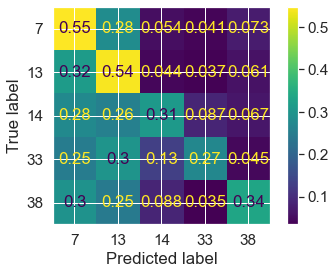

In [20]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn, X_te, Y_te, normalize='true')

In [27]:
from sklearn.tree import DecisionTreeClassifier
# Classify the top 5 manufacturer using a Decision Tree

best_depth = 1
best_test_acc = 0
best_train_acc = 0

for k in range(1,100):
    tree = DecisionTreeClassifier(max_depth=k)

    tree.fit(X_tr, Y_tr)

    tree_pred_train = tree.predict(X_tr)
    tree_pred_test = tree.predict(X_te)
    kacc = accuracy_score(Y_te, tree_pred_test)
    trainacc = accuracy_score(Y_tr, tree_pred_train)
    if kacc > best_test_acc:
        best_train_acc = trainacc
        best_test_acc = kacc
        best_depth = k
        
print("Best Depth:", best_depth)
print("Best Train Accuracy: ", best_train_acc)
print("Best Test Accuracy:", best_test_acc)

Best Depth: 19
Best Train Accuracy:  0.5722922784591467
Best Test Accuracy: 0.5123034660120405


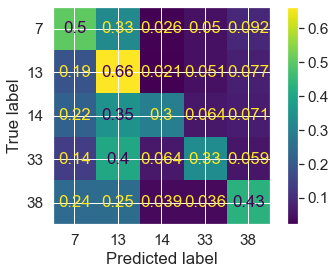

In [29]:
plot_confusion_matrix(tree, X_te, Y_te, normalize='true')

### Analysis

This second model aims to classify the manufacturer of the car by using features such as the paint type, size of the car, type of transmission etc. We decided to only use the top 5 manufacturers as to make it easier for the models and make the results easier to analyze. Since we only used non-categorical data for our first model, we decided to make use of our categorical data to see if we could use it to determine the manufacturer. 

After running a K nearest neighbors analysis, the training accuracy was 0.502 and the test accuracy was 0.461. We decided to use a confusion matrix to look deeper into the issues with the accuracy. It seems that there is a selection bias towards the two largest manufacturers (7 and 13). This makes sense, but luckily it does not seem to be too bad of a bias. The low results probably come simply from underfitting. The model is unable to make strong assumptions about the data.

Underwhelmed by our results with the KNN, we decided to try out a decision tree. To improve the accuracy, we optimized the max_depth. The decision tree did show slightly better results (train accuracy of .572 and test accuracy of .512), but it also seems to suffer from the same problems as the KNN (underfitting and a selection bias towards the largest manufacturers).

To answer our question (Given certain features, can we predict the manufacturer of the car?), I would argue that we can. Our accuracy is low, but our models are able to make at least some assumptions about the data. With better feature engineering and a stronger model, I believe we could predict the manufacturer more reliably.